In [1]:
from __future__ import print_function
from __future__ import division

import os
import math
import matplotlib.pyplot as plt

import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time
from voronoi_2d_binning import voronoi_2d_binning
from sklearn.neighbors import NearestNeighbors
import pickle
import imp # reload modules if necessary

import sys
sys.path.append('../astro_codes/')

% matplotlib inline
import matplotlib as mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [46]:
import dictionaries
import params
imp.reload(params)

data = Table.read(params.data_file)
output_directory = params.output_directory

os.mkdir(output_directory) if os.path.isdir(output_directory) is False else None

question_dictionary = dictionaries.questions
function_dictionary = dictionaries.function_dictionary

data_subset = data[:10000]

In [50]:
import params
imp.reload(params)

import sample
imp.reload(sample)

import debias
imp.reload(debias)

#questions = [q for q in question_dictionary.keys()]
questions = ['features','edgeon','spiral','spiralnumber']

for q in questions[2:3]:
    answers = question_dictionary[q]['answers']
    for a in answers:
        print('---------------------------------------------')
        print('Q: {}'.format(q))
        print('A: {}'.format(a))
        print('---------------------------------------------')
        data = debias.debias(data,question=q,answer=a,verbose=True)
        #fv, fv_debiased = debias.debias(data,question=q,answer=a,verbose=True,append_column=False)

---------------------------------------------
Q: spiral
A: spiral
---------------------------------------------
2367/10000 galaxies with p>0.5 and N>=5.
Bin-accretion...
23  initial bins.
Reassign bad bins...
18  good bins.
Modified Lloyd algorithm...
4  iterations.
Unbinned pixels:  1  /  118
Fractional S/N scatter (%): 33.1164796036


/Users/rosshart/Desktop/Debiasing/dictionaries.py:19: RuntimeWarning: divide by zero encountered in power
  r = np.exp(-k * (-x) ** c)


------------------
chisq (log) = 584.0
chisq (exp) = 355.8
------------------
=> exp function preferred
--- Selected function (k): ---
log(M),log(R),log(z)
--- Selected function (c): ---
linear(M),linear(R),linear(z)


/Users/rosshart/Desktop/Debiasing/fit.py:98: RuntimeWarning: invalid value encountered in log10
  term = constant*np.log10(var)
/Users/rosshart/anaconda/lib/python3.4/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/rosshart/Desktop/Debiasing/fit.py:239: RuntimeWarning: invalid value encountered in less_equal
  p[p <= f.min_] = f.min_
/Users/rosshart/Desktop/Debiasing/fit.py:240: RuntimeWarning: invalid value encountered in greater_equal
  p[p >= f.max_] = f.max_
/Users/rosshart/Desktop/Debiasing/dictionaries.py:32: RuntimeWarning: invalid value encountered in greater
  ok = k > 0


fit method preferred
---------
chi2 (bin) = 0.17
chi2 (fit) = 0.09
---------
---------------------------------------------
Q: spiral
A: no_spiral
---------------------------------------------
2367/10000 galaxies with p>0.5 and N>=5.
Bin-accretion...
23  initial bins.
Reassign bad bins...
18  good bins.
Modified Lloyd algorithm...
4  iterations.
Unbinned pixels:  1  /  118
Fractional S/N scatter (%): 33.1164796036
------------------
chisq (log) = 469.5
chisq (exp) = 331.2
------------------
=> exp function preferred
--- Selected function (k): ---
linear(M),linear(R),linear(z)
--- Selected function (c): ---
log(M),log(R),log(z)
fit method preferred
---------
chi2 (bin) = 0.39
chi2 (fit) = 0.25
---------


In [24]:
'''
fig, axarr = plt.subplots(1,3,figsize=(20,6.7))

for ax, a in zip(axarr,answers):
    colorz = data['Z_TONRY']
    fv = data['{}_{}_frac'.format(q,a)]
    fv_debiased = data['{}_{}_debiased'.format(q,a)]

    _ = ax.scatter(fv,fv_debiased,c=colorz,cmap=plt.cm.coolwarm,s=1)
    _ = ax.plot([0,1],[0,1],'k-')

    _ = ax.set_xlabel('$p_\mathrm{raw}$')
    _ = ax.set_ylabel('$p_\mathrm{debiased}$')
    _ = ax.set_xlim(0,1)
    _ = ax.set_ylim(0,1)
    
    _ = ax.text(0.05,0.95,a,transform=ax.transAxes,va='top',ha='left')
'''

"\nfig, axarr = plt.subplots(1,3,figsize=(20,6.7))\n\nfor ax, a in zip(axarr,answers):\n    colorz = data['Z_TONRY']\n    fv = data['{}_{}_frac'.format(q,a)]\n    fv_debiased = data['{}_{}_debiased'.format(q,a)]\n\n    _ = ax.scatter(fv,fv_debiased,c=colorz,cmap=plt.cm.coolwarm,s=1)\n    _ = ax.plot([0,1],[0,1],'k-')\n\n    _ = ax.set_xlabel('$p_\\mathrm{raw}$')\n    _ = ax.set_ylabel('$p_\\mathrm{debiased}$')\n    _ = ax.set_xlim(0,1)\n    _ = ax.set_ylim(0,1)\n    \n    _ = ax.text(0.05,0.95,a,transform=ax.transAxes,va='top',ha='left')\n"

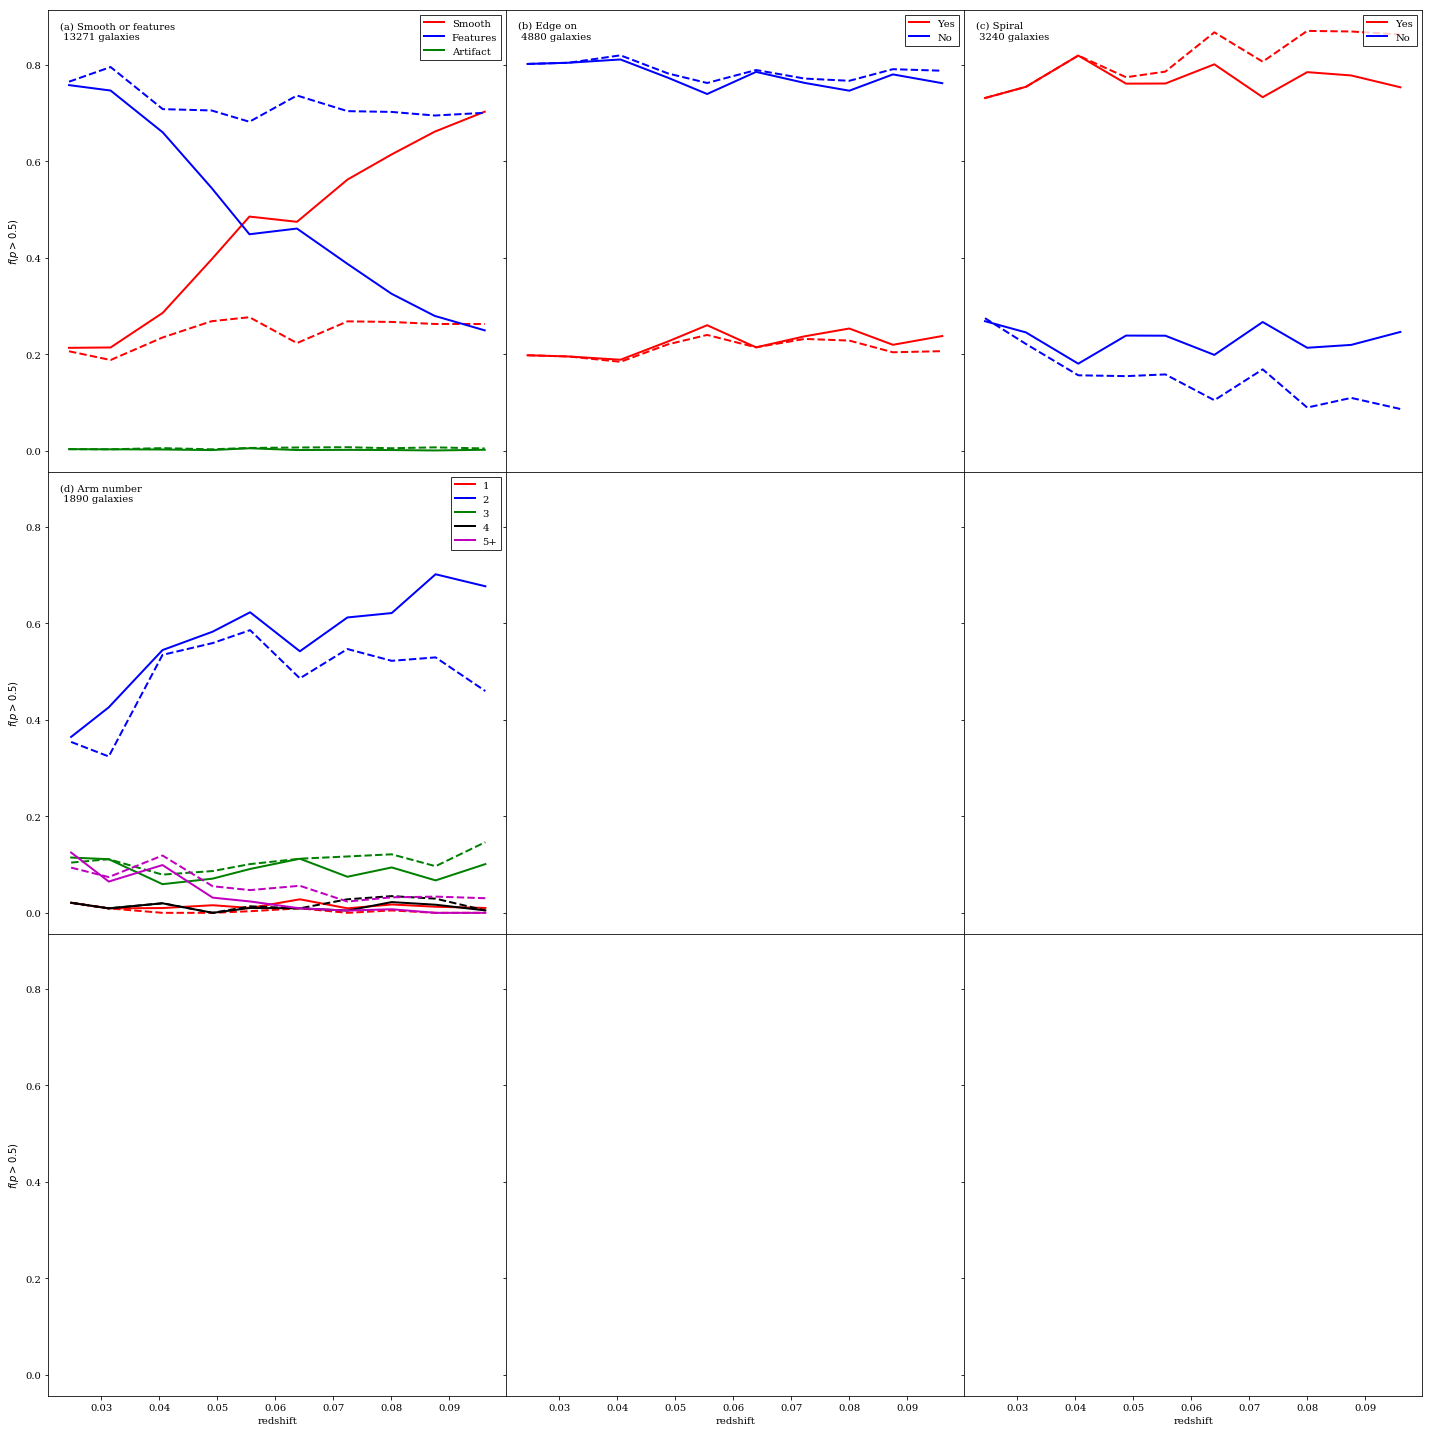

In [39]:
fig, axarr = plt.subplots(3,3,figsize=(20,20),sharex=True,sharey=True)
axarr = axarr.ravel()

import xy_plots
imp.reload(xy_plots)

import bin_statistics
imp.reload(bin_statistics)

from xy_plots import x_vs_y
from luminosities_magnitudes_and_distances import mag_to_Mag

Mag_limit = mag_to_Mag(19.8,0.1)
in_vl = np.all([data['Z_TONRY'] >= 0.02,data['Z_TONRY'] <= 0.1,data['absmag_r'] < Mag_limit],axis=0)

colors = 'rbgkmcy'
letters = 'abcdefghijklmnopqrstuvwxyz'

for q, ax, letter in zip(questions,axarr,letters):
    question = question_dictionary[q]
    questionlabel = question_dictionary[q]['questionlabel']
    answers = question_dictionary[q]['answers']
    answerlabels = question_dictionary[q]['answerlabels']
    pre_questions = question_dictionary[q]['pre_questions']
    pre_answers = question_dictionary[q]['pre_answers']
    
    if pre_questions is not None:
        p_q = 1
        for q_, a_ in zip(pre_questions,pre_answers):
            p_q *= data['{}_{}_frac'.format(q_,a_)]
        N_q = data['{}_total'.format(q)]
    else:
        p_q = 1
        N_q = 100
    
    sample_ok = (p_q > 0.5) & (N_q >= 5) & (in_vl)
    
    for a, alabel, color in zip(answers,answerlabels,colors):
        x = data['Z_TONRY'][sample_ok]
        y_raw = data['{}_{}_frac'.format(q,a)][sample_ok] > 0.5
        y_debiased = data['{}_{}_debiased'.format(q,a)][sample_ok] > 0.5
        xy_raw = xy_plots.x_vs_y(x,y_raw).fraction_with_feature(equal_N=False,bins=10)
        xy_debiased = xy_plots.x_vs_y(x,y_debiased).fraction_with_feature(equal_N=False,bins=10)
        
        xy_raw.line_plot(ax,color=color,label=alabel,lw=2)
        xy_debiased.line_plot(ax,color=color,label='_nolegend_',lw=2,linestyle='dashed')
        
    _ = ax.legend(fancybox=False,edgecolor='k',loc='upper right')
    
    label = '({}) {} \n {} galaxies'.format(letter,questionlabel,sample_ok.sum())
    _ = ax.text(0.025,0.975,label,transform=ax.transAxes,ha='left',va='top')

for x in [6,7,8]:
    _ = axarr[x].set_xlabel('redshift')       
for y in [0,3,6]:
    _ = axarr[y].set_ylabel('$f(p>0.5)$')

_ = fig.tight_layout()
_ = fig.subplots_adjust(hspace=0,wspace=0)

#fig.savefig('debiased_fractions.pdf')

In [24]:
data.write('GAMA_fits/fit_debiased.fits')